In [603]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [604]:
#Import datasets
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_holidays = pd.read_csv('holidays_events.csv')
data_oil = pd.read_csv('oil.csv')
data_stores = pd.read_csv('stores.csv')
data_transaction = pd.read_csv('transactions.csv')

Check whether there are any NaN in the datasets and observe datasets

In [605]:
data_train.isnull().any()

id             False
date           False
store_nbr      False
family         False
sales          False
onpromotion    False
dtype: bool

In [606]:
data_test.isnull().any()

id             False
date           False
store_nbr      False
family         False
onpromotion    False
dtype: bool

In [607]:
data_holidays.isnull().any()

date           False
type           False
locale         False
locale_name    False
description    False
transferred    False
dtype: bool

In [608]:
data_oil.isnull().any()

date          False
dcoilwtico     True
dtype: bool

In [609]:
#Fill the NaN with latest price
data_oil_new = pd.DataFrame()
data_oil_new = data_oil
for i in range(len(data_oil_new)):
    if data_oil_new.iloc[i][1] > 0:
        pass
    elif i != 0:
        data_oil_new['dcoilwtico'][i] = data_oil_new['dcoilwtico'][i-1]
data_oil_new['dcoilwtico'][0] = data_oil_new['dcoilwtico'][1]

<ipython-input-609-08942a82d58b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oil_new['dcoilwtico'][i] = data_oil_new['dcoilwtico'][i-1]
<ipython-input-609-08942a82d58b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_oil_new['dcoilwtico'][0] = data_oil_new['dcoilwtico'][1]


In [610]:
data_oil_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1218 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [611]:
data_stores.isnull().any()

store_nbr    False
city         False
state        False
type         False
cluster      False
dtype: bool

Data Visualization

<AxesSubplot:xlabel='date', ylabel='oil price'>

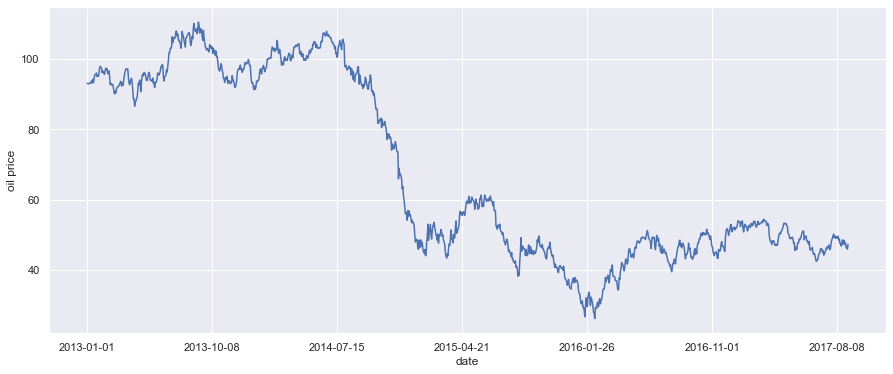

In [612]:
#Oil Price
data_oil_new_plot = data_oil_new.set_index('date')
data_oil_new_plot['dcoilwtico'].plot(figsize=(15, 6), ylabel='oil price')

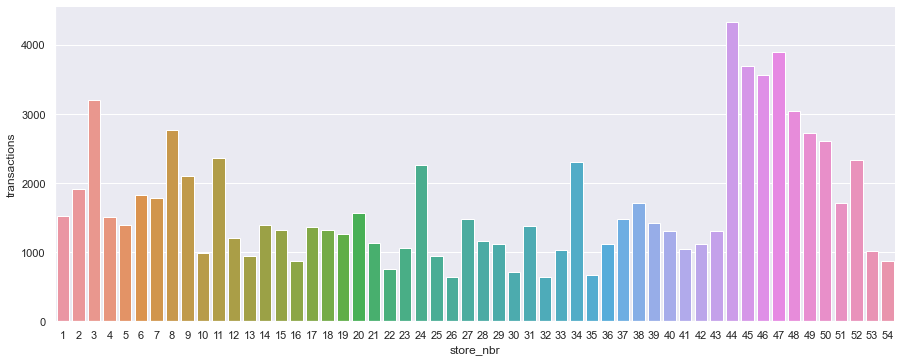

In [613]:
#Average transactions in each store
transstore = data_transaction.groupby("store_nbr").mean()
transstore = transstore.reset_index()
sns.catplot(data = transstore , x='store_nbr', y ='transactions', kind='bar', height=5, aspect=2.5)

<AxesSubplot:xlabel='date', ylabel='Transactions'>

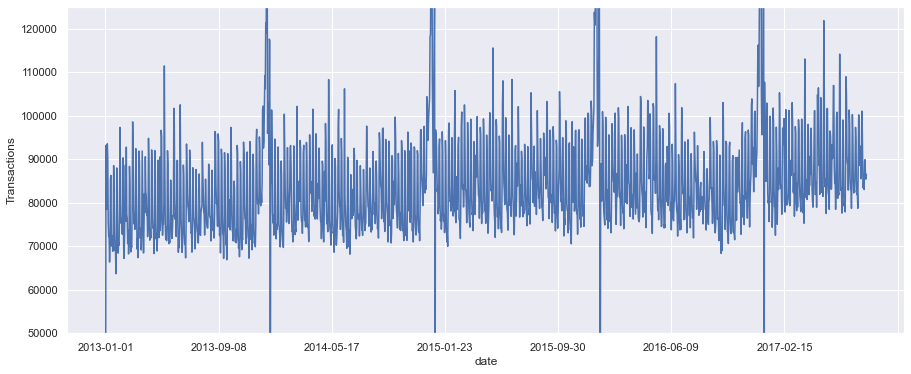

In [614]:
#Total transactions on each day
transdate = data_transaction.groupby("date").sum()
transdate = transdate.drop('store_nbr',axis =1)
transdate['transactions'].plot(figsize=(15, 6), ylim=(50000,125000), ylabel='Transactions')

Data Cleaning

In [615]:
df_train = data_train
df_train = df_train.merge(data_oil_new, how='left', on = 'date')
data_stores['country'] = 'Ecuador' 
df_train = df_train.merge(data_stores, how='left', on = 'store_nbr')

In [616]:
df_test = data_test
df_test = df_test.merge(data_oil_new, how='left', on = 'date')
df_test = df_test.merge(data_stores, how='left', on = 'store_nbr')

In [617]:
data_holidays_country = data_holidays.rename({"locale_name":"country"}, axis='columns')
df_train = df_train.merge(data_holidays_country, how='left', on = ['date', 'country'] )

In [618]:
df_test = df_test.merge(data_holidays_country, how='left', on = ['date', 'country'] )

In [619]:
df_train = df_train.drop(['country', 'type_y', 'description','transferred'], axis=1)
df_train['national_holiday'] = pd.get_dummies(df_train['locale'])
df_train = df_train.drop(['locale'], axis=1)

In [620]:
df_test = df_test.drop(['country', 'type_y', 'description','transferred'], axis=1)
df_test['national_holiday'] = 0
df_test = df_test.drop(['locale'], axis=1)

In [621]:
df_train = df_train.rename({"type_x" : "store_type"}, axis = 'columns')
df_test = df_test.rename({"type_x" : "store_type"}, axis = 'columns')

In [622]:
data_holidays_region = data_holidays.rename({"locale_name":"state"}, axis='columns')
df_train = df_train.merge(data_holidays_region, how='left', on = ['date', 'state'] )

In [623]:
df_test = df_test.merge(data_holidays_region, how='left', on = ['date', 'state'] )

In [624]:
df_train = df_train.drop(['type', 'description','transferred'], axis=1)
df_train['region_holiday'] = df_train['locale']=='Regional'
df_train = df_train.drop(['locale'], axis=1)

In [625]:
df_test = df_test.drop(['type', 'description','transferred'], axis=1)
df_test['region_holiday'] = df_test['locale']=='Regional'
df_test = df_test.drop(['locale'], axis=1)

In [626]:
data_holidays_city = data_holidays.rename({"locale_name":"city"}, axis='columns')
df_train = df_train.merge(data_holidays_city, how='left', on = ['date', 'city'] )
df_test = df_test.merge(data_holidays_city, how='left', on = ['date', 'city'] )

In [627]:
df_train = df_train.drop(['type', 'description','transferred'], axis=1)
df_train['city_holiday'] = df_train['locale']=='Local'
df_train = df_train.drop(['locale'], axis=1)

In [628]:
df_test = df_test.drop(['type', 'description','transferred'], axis=1)
df_test['city_holiday'] = df_test['locale']=='Local'
df_test = df_test.drop(['locale'], axis=1)

In [629]:
df_train = df_train.replace(to_replace = False, value =0)
df_train = df_train.replace(to_replace = True, value =1)

In [630]:
df_test = df_test.replace(to_replace = False, value =0)
df_test = df_test.replace(to_replace = True, value =1)

In [631]:
#df_train['holidays'] = (df_train["national_holiday"]>0) | (df_train["region_holiday"]>0) | (df_train["city_holiday"]>0)
#df_test['holidays'] = (df_test["national_holiday"]>0) | (df_test["region_holiday"]>0) | (df_test["city_holiday"]>0)

In [632]:
#df_train = df_train.replace(to_replace = False, value =0)
#df_train = df_train.replace(to_replace = True, value =1)
#df_test = df_test.replace(to_replace = False, value =0)
#df_test = df_test.replace(to_replace = True, value =1)

In [633]:
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,Quito,Pichincha,D,13,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,0,0,0
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,0,0,0
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,0,0,0
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,0,0,0


In [634]:
df_test

,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,Quito,Pichincha,D,13,0,0,0
1,3000889,2017-08-16,1,BABY CARE,0,46.80,Quito,Pichincha,D,13,0,0,0
2,3000890,2017-08-16,1,BEAUTY,2,46.80,Quito,Pichincha,D,13,0,0,0
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,Quito,Pichincha,D,13,0,0,0
4,3000892,2017-08-16,1,BOOKS,0,46.80,Quito,Pichincha,D,13,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,Quito,Pichincha,B,6,0,0,0
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,Quito,Pichincha,B,6,0,0,0
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,Quito,Pichincha,B,6,0,0,0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,Quito,Pichincha,B,6,0,0,0


Focus on data after 2017-01-01

In [635]:
df_train = df_train[df_train['date']>"2016-12-31"]

In [636]:
#Create month, day columns for train set
month_train=[]
day_train=[]
for i in range(len(df_train)):
    month_train.append(df_train.iloc[i][1][5:7])
    day_train.append(df_train.iloc[i][1][8:10])
df_train['month'] = month_train
df_train['day'] = day_train

<ipython-input-636-fcd025aa006b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['month'] = month_train
<ipython-input-636-fcd025aa006b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['day'] = day_train


In [637]:
#Create month, day columns for test set
month_test=[]
day_test=[]
for i in range(len(df_test)):
    month_test.append(df_test.iloc[i][1][5:7])
    day_test.append(df_test.iloc[i][1][8:10])
df_test['month'] = month_test
df_test['day'] = day_test

In [638]:
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day
2603766,2596374,2017-01-01,1,AUTOMOTIVE,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603767,2596375,2017-01-01,1,BABY CARE,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603768,2596376,2017-01-01,1,BEAUTY,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603769,2596377,2017-01-01,1,BEVERAGES,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
2603770,2596378,2017-01-01,1,BOOKS,0.000,0,NaN,Quito,Pichincha,D,13,1,0,0,01,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3008275,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008276,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008277,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Quito,Pichincha,B,6,0,0,0,08,15
3008278,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Quito,Pichincha,B,6,0,0,0,08,15


In [639]:
df_test

,id,date,store_nbr,family,onpromotion,dcoilwtico,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
1,3000889,2017-08-16,1,BABY CARE,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
2,3000890,2017-08-16,1,BEAUTY,2,46.80,Quito,Pichincha,D,13,0,0,0,08,16
3,3000891,2017-08-16,1,BEVERAGES,20,46.80,Quito,Pichincha,D,13,0,0,0,08,16
4,3000892,2017-08-16,1,BOOKS,0,46.80,Quito,Pichincha,D,13,0,0,0,08,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28508,3029396,2017-08-31,9,PREPARED FOODS,0,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28509,3029397,2017-08-31,9,PRODUCE,1,47.26,Quito,Pichincha,B,6,0,0,0,08,31
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,Quito,Pichincha,B,6,0,0,0,08,31


In [640]:
#Split train set into train set and validation set
data_train = df_train[df_train['date']<="2017-07-15"]
data_val = df_train[df_train['date']>"2017-07-15"]
data_test = df_test

In [641]:
#Create weekday column for train set
train_date = []
for j in range(len(data_train)):
    train_date.append(datetime.strptime(data_train.iloc[j][1],"%Y-%m-%d"))
s_train_date = pd.Series(train_date)
s_train_date = s_train_date.dt.weekday
s_train_date = s_train_date.tolist()
data_train['weekday'] = s_train_date

<ipython-input-641-0287c5d5b2e8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['weekday'] = s_train_date


In [642]:
#Create weekday column for validation set
val_date = []
for j in range(len(data_val)):
    val_date.append(datetime.strptime(data_val.iloc[j][1],"%Y-%m-%d"))
s_val_date = pd.Series(val_date)
s_val_date = s_val_date.dt.weekday
s_val_date = s_val_date.tolist()
data_val['weekday'] = s_val_date

<ipython-input-642-290e4575e13d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val['weekday'] = s_val_date


In [643]:
#Create weekday column for test set
test_date = []
for j in range(len(data_test)):
    test_date.append(datetime.strptime(data_test.iloc[j][1],"%Y-%m-%d"))
s_test_date = pd.Series(test_date)
s_test_date = s_test_date.dt.weekday
s_test_date = s_test_date.tolist()
data_test['weekday'] = s_test_date

In [644]:
#Drop duplicate columns
data_train = data_train.drop(['id'], axis=1)
data_val = data_val.drop(['id'], axis=1)
data_test = data_test.drop(['id'], axis=1)

In [645]:
X_train = data_train.drop(['sales'],axis=1)
y_train = data_train['sales']
X_val = data_val.drop(['sales'],axis=1)
y_val = data_val['sales']

In [646]:
X_train.isnull().any()

date                False
store_nbr           False
family              False
onpromotion         False
dcoilwtico           True
city                False
state               False
store_type          False
cluster             False
national_holiday    False
region_holiday      False
city_holiday        False
month               False
day                 False
weekday             False
dtype: bool

In [647]:
#Use average oil price to fill oil na in train set
train_oil_new = pd.DataFrame()
train_oil_new['date'] = data_train['date']
train_oil_new = train_oil_new.merge(data_oil_new, how='left', on = 'date')
train_oil_new['month'] = train_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
train_oil_new['month_avg'] = train_oil_new.groupby('month')['dcoilwtico'].transform('mean')
train_oil_new['tmp'] = train_oil_new['dcoilwtico'].map(np.isnan)
train_oil_new['month_avg'] = train_oil_new['tmp'] * train_oil_new['month_avg']
train_oil_new['dcoilwtico'].fillna(0, inplace=True)
train_oil_new['oil'] = train_oil_new['dcoilwtico'] + train_oil_new['month_avg']
train_oil_new = train_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
train_oil = train_oil_new['oil'].tolist()
X_train['oil'] = train_oil

In [648]:
#Use average oil price to fill oil na in validation set
val_oil_new = pd.DataFrame()
val_oil_new['date'] = data_val['date']
val_oil_new = val_oil_new.merge(data_oil_new, how='left', on = 'date')
val_oil_new['month'] = val_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
val_oil_new['month_avg'] = val_oil_new.groupby('month')['dcoilwtico'].transform('mean')
val_oil_new['tmp'] = val_oil_new['dcoilwtico'].map(np.isnan)
val_oil_new['month_avg'] = val_oil_new['tmp'] * val_oil_new['month_avg']
val_oil_new['dcoilwtico'].fillna(0, inplace=True)
val_oil_new['oil'] = val_oil_new['dcoilwtico'] + val_oil_new['month_avg']
val_oil_new = val_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
val_oil = val_oil_new['oil'].tolist()
X_val['oil'] = val_oil

In [649]:
#Use average oil price to fill oil na in test set
test_oil_new = pd.DataFrame()
test_oil_new['date'] = data_test['date']
test_oil_new = test_oil_new.merge(data_oil_new, how='left', on = 'date')
test_oil_new['month'] = test_oil_new['date'].map(lambda x: int(x.replace('-', '')[:6]))
test_oil_new['month_avg'] = test_oil_new.groupby('month')['dcoilwtico'].transform('mean')
test_oil_new['tmp'] = test_oil_new['dcoilwtico'].map(np.isnan)
test_oil_new['month_avg'] = test_oil_new['tmp'] * test_oil_new['month_avg']
test_oil_new['dcoilwtico'].fillna(0, inplace=True)
test_oil_new['oil'] = test_oil_new['dcoilwtico'] + test_oil_new['month_avg']
test_oil_new = test_oil_new.drop(['month', 'month_avg', 'tmp','dcoilwtico'], axis=1)
test_oil = test_oil_new['oil'].tolist()
data_test['oil'] = test_oil

In [650]:
X_train = X_train.drop(['dcoilwtico', 'date'], axis=1)
X_val = X_val.drop(['dcoilwtico', 'date'], axis=1)
data_test = data_test.drop(['dcoilwtico', 'date'], axis=1)

In [651]:
#Apply labelencoder to deal with the categorize factors
cat_features = ['family', 'store_nbr', 'city', 'state', 'store_type', 'cluster']
for col in cat_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_val[col] = le.fit_transform(X_val[col])
    data_test[col] = le.transform(data_test[col])

In [652]:
train_test_data = pd.concat([X_train,X_val])
train_test_data = pd.concat([train_test_data,data_test])

In [653]:
train_test_data

,store_nbr,family,onpromotion,city,state,store_type,cluster,national_holiday,region_holiday,city_holiday,month,day,weekday,oil
2603766,0,0,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603767,0,1,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603768,0,2,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603769,0,3,0,18,12,3,12,1,0,0,01,01,6,52.554091
2603770,0,4,0,18,12,3,12,1,0,0,01,01,6,52.554091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,8,28,1,18,12,1,5,0,0,0,08,31,3,47.260000
28508,8,29,0,18,12,1,5,0,0,0,08,31,3,47.260000
28509,8,30,1,18,12,1,5,0,0,0,08,31,3,47.260000
28510,8,31,9,18,12,1,5,0,0,0,08,31,3,47.260000


In [654]:
train_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433026 entries, 2603766 to 28511
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   store_nbr         433026 non-null  int64  
 1   family            433026 non-null  int64  
 2   onpromotion       433026 non-null  int64  
 3   city              433026 non-null  int64  
 4   state             433026 non-null  int64  
 5   store_type        433026 non-null  int64  
 6   cluster           433026 non-null  int64  
 7   national_holiday  433026 non-null  int64  
 8   region_holiday    433026 non-null  int64  
 9   city_holiday      433026 non-null  int64  
 10  month             433026 non-null  object 
 11  day               433026 non-null  object 
 12  weekday           433026 non-null  int64  
 13  oil               433026 non-null  float64
dtypes: float64(1), int64(11), object(2)
memory usage: 49.6+ MB


In [441]:
#Create weekday, month, day dummy variables
weekday_dummy = pd.get_dummies(train_test_data['weekday'], prefix ='weekday')
month_dummy = pd.get_dummies(train_test_data['month'], prefix ='month')
day_dummy = pd.get_dummies(train_test_data['day'], prefix ='day')

In [442]:
train_test_data = pd.concat([train_test_data,weekday_dummy], axis =1)
train_test_data = pd.concat([train_test_data,month_dummy], axis =1)
train_test_data = pd.concat([train_test_data,day_dummy], axis =1)
train_test_data = train_test_data.drop(['month', 'day','weekday'], axis=1)

In [443]:
#Standardize the oil price 
ooil = train_test_data['oil'].tolist()
mean_oil = np.mean(ooil)
std_oil = np.std(ooil)
for i in range(len(ooil)):
    ooil[i] = (ooil[i]-mean_oil)/std_oil
train_test_data['oil'] = ooil

In [444]:
#scaler = MinMaxScaler()
#scaler.fit(train_test_data)
#train_test_data['oil'] = scaler.transform(train_test_data['oil'])

In [445]:
#Split dataset into train, validation, and test sets
X_train = train_test_data[:len(X_train)]
X_val = train_test_data[len(X_train):len(X_train)+len(X_val)]
X_test = train_test_data[len(X_train)+len(X_val):]

In [446]:
#Apply log to transfer the sales
y_train = np.log(y_train+1) 
y_val = np.log(y_val+1)

In [455]:
#Model XGBOOST
xgbr = xgb.XGBRegressor(max_depth =11, n_estimators =5000, learning_rate =0.01, 
                        subsample =0.99, reg_alpha =10, reg_lambda=0.2, colsample_bytree=0.8)
xgbr.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric = 'rmse')

[0]	validation_0-rmse:3.95386	validation_1-rmse:3.97658
[1]	validation_0-rmse:3.91983	validation_1-rmse:3.94333
[2]	validation_0-rmse:3.88160	validation_1-rmse:3.90511
[3]	validation_0-rmse:3.84380	validation_1-rmse:3.86722
[4]	validation_0-rmse:3.80639	validation_1-rmse:3.82987
[5]	validation_0-rmse:3.77007	validation_1-rmse:3.79311
[6]	validation_0-rmse:3.73779	validation_1-rmse:3.76162
[7]	validation_0-rmse:3.70139	validation_1-rmse:3.72524
[8]	validation_0-rmse:3.66544	validation_1-rmse:3.68921
[9]	validation_0-rmse:3.63017	validation_1-rmse:3.65406
[10]	validation_0-rmse:3.59485	validation_1-rmse:3.61870
[11]	validation_0-rmse:3.55991	validation_1-rmse:3.58360
[12]	validation_0-rmse:3.52533	validation_1-rmse:3.54909
[13]	validation_0-rmse:3.49536	validation_1-rmse:3.51995
[14]	validation_0-rmse:3.46154	validation_1-rmse:3.48606
[15]	validation_0-rmse:3.42800	validation_1-rmse:3.45244
[16]	validation_0-rmse:3.39477	validation_1-rmse:3.41912
[17]	validation_0-rmse:3.36185	validation

[144]	validation_0-rmse:1.10983	validation_1-rmse:1.14345
[145]	validation_0-rmse:1.10080	validation_1-rmse:1.13442
[146]	validation_0-rmse:1.09184	validation_1-rmse:1.12554
[147]	validation_0-rmse:1.08299	validation_1-rmse:1.11672
[148]	validation_0-rmse:1.07427	validation_1-rmse:1.10803
[149]	validation_0-rmse:1.06563	validation_1-rmse:1.09943
[150]	validation_0-rmse:1.05702	validation_1-rmse:1.09085
[151]	validation_0-rmse:1.04860	validation_1-rmse:1.08252
[152]	validation_0-rmse:1.04022	validation_1-rmse:1.07421
[153]	validation_0-rmse:1.03195	validation_1-rmse:1.06597
[154]	validation_0-rmse:1.02380	validation_1-rmse:1.05796
[155]	validation_0-rmse:1.01730	validation_1-rmse:1.05172
[156]	validation_0-rmse:1.01092	validation_1-rmse:1.04562
[157]	validation_0-rmse:1.00298	validation_1-rmse:1.03773
[158]	validation_0-rmse:0.99517	validation_1-rmse:1.02996
[159]	validation_0-rmse:0.98743	validation_1-rmse:1.02233
[160]	validation_0-rmse:0.97979	validation_1-rmse:1.01477
[161]	validati

[286]	validation_0-rmse:0.50419	validation_1-rmse:0.55899
[287]	validation_0-rmse:0.50250	validation_1-rmse:0.55750
[288]	validation_0-rmse:0.50082	validation_1-rmse:0.55607
[289]	validation_0-rmse:0.49964	validation_1-rmse:0.55508
[290]	validation_0-rmse:0.49803	validation_1-rmse:0.55361
[291]	validation_0-rmse:0.49645	validation_1-rmse:0.55218
[292]	validation_0-rmse:0.49485	validation_1-rmse:0.55080
[293]	validation_0-rmse:0.49327	validation_1-rmse:0.54936
[294]	validation_0-rmse:0.49172	validation_1-rmse:0.54798
[295]	validation_0-rmse:0.49011	validation_1-rmse:0.54653
[296]	validation_0-rmse:0.48863	validation_1-rmse:0.54526
[297]	validation_0-rmse:0.48713	validation_1-rmse:0.54390
[298]	validation_0-rmse:0.48564	validation_1-rmse:0.54262
[299]	validation_0-rmse:0.48423	validation_1-rmse:0.54139
[300]	validation_0-rmse:0.48280	validation_1-rmse:0.54010
[301]	validation_0-rmse:0.48142	validation_1-rmse:0.53890
[302]	validation_0-rmse:0.48008	validation_1-rmse:0.53775
[303]	validati

[428]	validation_0-rmse:0.39335	validation_1-rmse:0.46803
[429]	validation_0-rmse:0.39297	validation_1-rmse:0.46773
[430]	validation_0-rmse:0.39274	validation_1-rmse:0.46761
[431]	validation_0-rmse:0.39252	validation_1-rmse:0.46747
[432]	validation_0-rmse:0.39220	validation_1-rmse:0.46726
[433]	validation_0-rmse:0.39184	validation_1-rmse:0.46699
[434]	validation_0-rmse:0.39152	validation_1-rmse:0.46677
[435]	validation_0-rmse:0.39116	validation_1-rmse:0.46651
[436]	validation_0-rmse:0.39081	validation_1-rmse:0.46625
[437]	validation_0-rmse:0.39047	validation_1-rmse:0.46598
[438]	validation_0-rmse:0.39024	validation_1-rmse:0.46584
[439]	validation_0-rmse:0.38990	validation_1-rmse:0.46558
[440]	validation_0-rmse:0.38968	validation_1-rmse:0.46547
[441]	validation_0-rmse:0.38934	validation_1-rmse:0.46518
[442]	validation_0-rmse:0.38898	validation_1-rmse:0.46493
[443]	validation_0-rmse:0.38876	validation_1-rmse:0.46480
[444]	validation_0-rmse:0.38846	validation_1-rmse:0.46459
[445]	validati

[570]	validation_0-rmse:0.36287	validation_1-rmse:0.44891
[571]	validation_0-rmse:0.36276	validation_1-rmse:0.44889
[572]	validation_0-rmse:0.36270	validation_1-rmse:0.44888
[573]	validation_0-rmse:0.36254	validation_1-rmse:0.44879
[574]	validation_0-rmse:0.36238	validation_1-rmse:0.44871
[575]	validation_0-rmse:0.36223	validation_1-rmse:0.44863
[576]	validation_0-rmse:0.36207	validation_1-rmse:0.44855
[577]	validation_0-rmse:0.36191	validation_1-rmse:0.44846
[578]	validation_0-rmse:0.36177	validation_1-rmse:0.44840
[579]	validation_0-rmse:0.36164	validation_1-rmse:0.44832
[580]	validation_0-rmse:0.36148	validation_1-rmse:0.44824
[581]	validation_0-rmse:0.36133	validation_1-rmse:0.44816
[582]	validation_0-rmse:0.36117	validation_1-rmse:0.44808
[583]	validation_0-rmse:0.36103	validation_1-rmse:0.44801
[584]	validation_0-rmse:0.36086	validation_1-rmse:0.44790
[585]	validation_0-rmse:0.36077	validation_1-rmse:0.44788
[586]	validation_0-rmse:0.36061	validation_1-rmse:0.44779
[587]	validati

[712]	validation_0-rmse:0.34795	validation_1-rmse:0.44190
[713]	validation_0-rmse:0.34788	validation_1-rmse:0.44187
[714]	validation_0-rmse:0.34782	validation_1-rmse:0.44184
[715]	validation_0-rmse:0.34774	validation_1-rmse:0.44182
[716]	validation_0-rmse:0.34767	validation_1-rmse:0.44180
[717]	validation_0-rmse:0.34759	validation_1-rmse:0.44178
[718]	validation_0-rmse:0.34752	validation_1-rmse:0.44177
[719]	validation_0-rmse:0.34744	validation_1-rmse:0.44175
[720]	validation_0-rmse:0.34737	validation_1-rmse:0.44173
[721]	validation_0-rmse:0.34729	validation_1-rmse:0.44171
[722]	validation_0-rmse:0.34722	validation_1-rmse:0.44167
[723]	validation_0-rmse:0.34718	validation_1-rmse:0.44168
[724]	validation_0-rmse:0.34712	validation_1-rmse:0.44165
[725]	validation_0-rmse:0.34703	validation_1-rmse:0.44160
[726]	validation_0-rmse:0.34694	validation_1-rmse:0.44155
[727]	validation_0-rmse:0.34687	validation_1-rmse:0.44151
[728]	validation_0-rmse:0.34682	validation_1-rmse:0.44150
[729]	validati

[854]	validation_0-rmse:0.33988	validation_1-rmse:0.43910
[855]	validation_0-rmse:0.33985	validation_1-rmse:0.43909
[856]	validation_0-rmse:0.33980	validation_1-rmse:0.43906
[857]	validation_0-rmse:0.33977	validation_1-rmse:0.43905
[858]	validation_0-rmse:0.33975	validation_1-rmse:0.43905
[859]	validation_0-rmse:0.33972	validation_1-rmse:0.43903
[860]	validation_0-rmse:0.33968	validation_1-rmse:0.43903
[861]	validation_0-rmse:0.33964	validation_1-rmse:0.43902
[862]	validation_0-rmse:0.33957	validation_1-rmse:0.43900
[863]	validation_0-rmse:0.33953	validation_1-rmse:0.43897
[864]	validation_0-rmse:0.33950	validation_1-rmse:0.43896
[865]	validation_0-rmse:0.33947	validation_1-rmse:0.43896
[866]	validation_0-rmse:0.33942	validation_1-rmse:0.43894
[867]	validation_0-rmse:0.33940	validation_1-rmse:0.43894
[868]	validation_0-rmse:0.33938	validation_1-rmse:0.43893
[869]	validation_0-rmse:0.33935	validation_1-rmse:0.43893
[870]	validation_0-rmse:0.33929	validation_1-rmse:0.43891
[871]	validati

[996]	validation_0-rmse:0.33460	validation_1-rmse:0.43736
[997]	validation_0-rmse:0.33457	validation_1-rmse:0.43736
[998]	validation_0-rmse:0.33455	validation_1-rmse:0.43736
[999]	validation_0-rmse:0.33453	validation_1-rmse:0.43735
[1000]	validation_0-rmse:0.33449	validation_1-rmse:0.43734
[1001]	validation_0-rmse:0.33447	validation_1-rmse:0.43735
[1002]	validation_0-rmse:0.33443	validation_1-rmse:0.43733
[1003]	validation_0-rmse:0.33440	validation_1-rmse:0.43732
[1004]	validation_0-rmse:0.33436	validation_1-rmse:0.43730
[1005]	validation_0-rmse:0.33432	validation_1-rmse:0.43729
[1006]	validation_0-rmse:0.33428	validation_1-rmse:0.43727
[1007]	validation_0-rmse:0.33423	validation_1-rmse:0.43728
[1008]	validation_0-rmse:0.33419	validation_1-rmse:0.43727
[1009]	validation_0-rmse:0.33414	validation_1-rmse:0.43725
[1010]	validation_0-rmse:0.33412	validation_1-rmse:0.43725
[1011]	validation_0-rmse:0.33408	validation_1-rmse:0.43723
[1012]	validation_0-rmse:0.33404	validation_1-rmse:0.43722
[

[1135]	validation_0-rmse:0.33035	validation_1-rmse:0.43615
[1136]	validation_0-rmse:0.33031	validation_1-rmse:0.43614
[1137]	validation_0-rmse:0.33028	validation_1-rmse:0.43613
[1138]	validation_0-rmse:0.33024	validation_1-rmse:0.43611
[1139]	validation_0-rmse:0.33022	validation_1-rmse:0.43612
[1140]	validation_0-rmse:0.33019	validation_1-rmse:0.43611
[1141]	validation_0-rmse:0.33016	validation_1-rmse:0.43609
[1142]	validation_0-rmse:0.33013	validation_1-rmse:0.43607
[1143]	validation_0-rmse:0.33010	validation_1-rmse:0.43606
[1144]	validation_0-rmse:0.33006	validation_1-rmse:0.43605
[1145]	validation_0-rmse:0.33003	validation_1-rmse:0.43604
[1146]	validation_0-rmse:0.32999	validation_1-rmse:0.43602
[1147]	validation_0-rmse:0.32996	validation_1-rmse:0.43602
[1148]	validation_0-rmse:0.32994	validation_1-rmse:0.43601
[1149]	validation_0-rmse:0.32991	validation_1-rmse:0.43600
[1150]	validation_0-rmse:0.32987	validation_1-rmse:0.43599
[1151]	validation_0-rmse:0.32985	validation_1-rmse:0.435

[1274]	validation_0-rmse:0.32668	validation_1-rmse:0.43504
[1275]	validation_0-rmse:0.32666	validation_1-rmse:0.43504
[1276]	validation_0-rmse:0.32665	validation_1-rmse:0.43504
[1277]	validation_0-rmse:0.32664	validation_1-rmse:0.43503
[1278]	validation_0-rmse:0.32663	validation_1-rmse:0.43503
[1279]	validation_0-rmse:0.32662	validation_1-rmse:0.43503
[1280]	validation_0-rmse:0.32661	validation_1-rmse:0.43503
[1281]	validation_0-rmse:0.32658	validation_1-rmse:0.43501
[1282]	validation_0-rmse:0.32656	validation_1-rmse:0.43501
[1283]	validation_0-rmse:0.32654	validation_1-rmse:0.43500
[1284]	validation_0-rmse:0.32652	validation_1-rmse:0.43500
[1285]	validation_0-rmse:0.32649	validation_1-rmse:0.43498
[1286]	validation_0-rmse:0.32646	validation_1-rmse:0.43498
[1287]	validation_0-rmse:0.32644	validation_1-rmse:0.43498
[1288]	validation_0-rmse:0.32642	validation_1-rmse:0.43497
[1289]	validation_0-rmse:0.32639	validation_1-rmse:0.43496
[1290]	validation_0-rmse:0.32637	validation_1-rmse:0.434

[1413]	validation_0-rmse:0.32378	validation_1-rmse:0.43436
[1414]	validation_0-rmse:0.32375	validation_1-rmse:0.43435
[1415]	validation_0-rmse:0.32373	validation_1-rmse:0.43434
[1416]	validation_0-rmse:0.32370	validation_1-rmse:0.43433
[1417]	validation_0-rmse:0.32367	validation_1-rmse:0.43432
[1418]	validation_0-rmse:0.32365	validation_1-rmse:0.43432
[1419]	validation_0-rmse:0.32362	validation_1-rmse:0.43431
[1420]	validation_0-rmse:0.32361	validation_1-rmse:0.43431
[1421]	validation_0-rmse:0.32359	validation_1-rmse:0.43430
[1422]	validation_0-rmse:0.32357	validation_1-rmse:0.43429
[1423]	validation_0-rmse:0.32356	validation_1-rmse:0.43429
[1424]	validation_0-rmse:0.32353	validation_1-rmse:0.43429
[1425]	validation_0-rmse:0.32351	validation_1-rmse:0.43429
[1426]	validation_0-rmse:0.32350	validation_1-rmse:0.43429
[1427]	validation_0-rmse:0.32349	validation_1-rmse:0.43428
[1428]	validation_0-rmse:0.32347	validation_1-rmse:0.43428
[1429]	validation_0-rmse:0.32344	validation_1-rmse:0.434

[1552]	validation_0-rmse:0.32135	validation_1-rmse:0.43380
[1553]	validation_0-rmse:0.32133	validation_1-rmse:0.43380
[1554]	validation_0-rmse:0.32132	validation_1-rmse:0.43379
[1555]	validation_0-rmse:0.32129	validation_1-rmse:0.43380
[1556]	validation_0-rmse:0.32127	validation_1-rmse:0.43379
[1557]	validation_0-rmse:0.32126	validation_1-rmse:0.43379
[1558]	validation_0-rmse:0.32124	validation_1-rmse:0.43379
[1559]	validation_0-rmse:0.32123	validation_1-rmse:0.43378
[1560]	validation_0-rmse:0.32121	validation_1-rmse:0.43378
[1561]	validation_0-rmse:0.32120	validation_1-rmse:0.43378
[1562]	validation_0-rmse:0.32118	validation_1-rmse:0.43378
[1563]	validation_0-rmse:0.32116	validation_1-rmse:0.43378
[1564]	validation_0-rmse:0.32115	validation_1-rmse:0.43378
[1565]	validation_0-rmse:0.32114	validation_1-rmse:0.43377
[1566]	validation_0-rmse:0.32111	validation_1-rmse:0.43377
[1567]	validation_0-rmse:0.32110	validation_1-rmse:0.43377
[1568]	validation_0-rmse:0.32109	validation_1-rmse:0.433

[1691]	validation_0-rmse:0.31925	validation_1-rmse:0.43343
[1692]	validation_0-rmse:0.31923	validation_1-rmse:0.43343
[1693]	validation_0-rmse:0.31922	validation_1-rmse:0.43343
[1694]	validation_0-rmse:0.31920	validation_1-rmse:0.43342
[1695]	validation_0-rmse:0.31918	validation_1-rmse:0.43342
[1696]	validation_0-rmse:0.31916	validation_1-rmse:0.43341
[1697]	validation_0-rmse:0.31915	validation_1-rmse:0.43342
[1698]	validation_0-rmse:0.31912	validation_1-rmse:0.43342
[1699]	validation_0-rmse:0.31911	validation_1-rmse:0.43342
[1700]	validation_0-rmse:0.31911	validation_1-rmse:0.43341
[1701]	validation_0-rmse:0.31909	validation_1-rmse:0.43341
[1702]	validation_0-rmse:0.31907	validation_1-rmse:0.43341
[1703]	validation_0-rmse:0.31906	validation_1-rmse:0.43341
[1704]	validation_0-rmse:0.31905	validation_1-rmse:0.43341
[1705]	validation_0-rmse:0.31903	validation_1-rmse:0.43341
[1706]	validation_0-rmse:0.31902	validation_1-rmse:0.43341
[1707]	validation_0-rmse:0.31901	validation_1-rmse:0.433

[1830]	validation_0-rmse:0.31735	validation_1-rmse:0.43324
[1831]	validation_0-rmse:0.31734	validation_1-rmse:0.43324
[1832]	validation_0-rmse:0.31733	validation_1-rmse:0.43323
[1833]	validation_0-rmse:0.31731	validation_1-rmse:0.43323
[1834]	validation_0-rmse:0.31730	validation_1-rmse:0.43323
[1835]	validation_0-rmse:0.31728	validation_1-rmse:0.43323
[1836]	validation_0-rmse:0.31727	validation_1-rmse:0.43323
[1837]	validation_0-rmse:0.31726	validation_1-rmse:0.43322
[1838]	validation_0-rmse:0.31724	validation_1-rmse:0.43322
[1839]	validation_0-rmse:0.31723	validation_1-rmse:0.43323
[1840]	validation_0-rmse:0.31721	validation_1-rmse:0.43323
[1841]	validation_0-rmse:0.31720	validation_1-rmse:0.43323
[1842]	validation_0-rmse:0.31718	validation_1-rmse:0.43323
[1843]	validation_0-rmse:0.31717	validation_1-rmse:0.43322
[1844]	validation_0-rmse:0.31715	validation_1-rmse:0.43322
[1845]	validation_0-rmse:0.31713	validation_1-rmse:0.43322
[1846]	validation_0-rmse:0.31712	validation_1-rmse:0.433

[1969]	validation_0-rmse:0.31570	validation_1-rmse:0.43303
[1970]	validation_0-rmse:0.31568	validation_1-rmse:0.43303
[1971]	validation_0-rmse:0.31567	validation_1-rmse:0.43303
[1972]	validation_0-rmse:0.31566	validation_1-rmse:0.43303
[1973]	validation_0-rmse:0.31565	validation_1-rmse:0.43303
[1974]	validation_0-rmse:0.31564	validation_1-rmse:0.43302
[1975]	validation_0-rmse:0.31562	validation_1-rmse:0.43302
[1976]	validation_0-rmse:0.31561	validation_1-rmse:0.43302
[1977]	validation_0-rmse:0.31560	validation_1-rmse:0.43302
[1978]	validation_0-rmse:0.31558	validation_1-rmse:0.43302
[1979]	validation_0-rmse:0.31556	validation_1-rmse:0.43302
[1980]	validation_0-rmse:0.31555	validation_1-rmse:0.43302
[1981]	validation_0-rmse:0.31554	validation_1-rmse:0.43302
[1982]	validation_0-rmse:0.31552	validation_1-rmse:0.43302
[1983]	validation_0-rmse:0.31551	validation_1-rmse:0.43301
[1984]	validation_0-rmse:0.31549	validation_1-rmse:0.43300
[1985]	validation_0-rmse:0.31549	validation_1-rmse:0.433

[2108]	validation_0-rmse:0.31415	validation_1-rmse:0.43285
[2109]	validation_0-rmse:0.31414	validation_1-rmse:0.43285
[2110]	validation_0-rmse:0.31413	validation_1-rmse:0.43285
[2111]	validation_0-rmse:0.31412	validation_1-rmse:0.43285
[2112]	validation_0-rmse:0.31410	validation_1-rmse:0.43285
[2113]	validation_0-rmse:0.31409	validation_1-rmse:0.43285
[2114]	validation_0-rmse:0.31408	validation_1-rmse:0.43285
[2115]	validation_0-rmse:0.31407	validation_1-rmse:0.43285
[2116]	validation_0-rmse:0.31407	validation_1-rmse:0.43285
[2117]	validation_0-rmse:0.31405	validation_1-rmse:0.43285
[2118]	validation_0-rmse:0.31404	validation_1-rmse:0.43285
[2119]	validation_0-rmse:0.31404	validation_1-rmse:0.43285
[2120]	validation_0-rmse:0.31402	validation_1-rmse:0.43284
[2121]	validation_0-rmse:0.31401	validation_1-rmse:0.43284
[2122]	validation_0-rmse:0.31400	validation_1-rmse:0.43284
[2123]	validation_0-rmse:0.31399	validation_1-rmse:0.43284
[2124]	validation_0-rmse:0.31398	validation_1-rmse:0.432

[2247]	validation_0-rmse:0.31285	validation_1-rmse:0.43276
[2248]	validation_0-rmse:0.31284	validation_1-rmse:0.43275
[2249]	validation_0-rmse:0.31283	validation_1-rmse:0.43276
[2250]	validation_0-rmse:0.31282	validation_1-rmse:0.43276
[2251]	validation_0-rmse:0.31280	validation_1-rmse:0.43276
[2252]	validation_0-rmse:0.31279	validation_1-rmse:0.43275
[2253]	validation_0-rmse:0.31279	validation_1-rmse:0.43275
[2254]	validation_0-rmse:0.31278	validation_1-rmse:0.43275
[2255]	validation_0-rmse:0.31277	validation_1-rmse:0.43275
[2256]	validation_0-rmse:0.31276	validation_1-rmse:0.43275
[2257]	validation_0-rmse:0.31275	validation_1-rmse:0.43275
[2258]	validation_0-rmse:0.31274	validation_1-rmse:0.43275
[2259]	validation_0-rmse:0.31273	validation_1-rmse:0.43274
[2260]	validation_0-rmse:0.31272	validation_1-rmse:0.43275
[2261]	validation_0-rmse:0.31271	validation_1-rmse:0.43275
[2262]	validation_0-rmse:0.31271	validation_1-rmse:0.43275
[2263]	validation_0-rmse:0.31270	validation_1-rmse:0.432

[2386]	validation_0-rmse:0.31161	validation_1-rmse:0.43272
[2387]	validation_0-rmse:0.31161	validation_1-rmse:0.43272
[2388]	validation_0-rmse:0.31159	validation_1-rmse:0.43272
[2389]	validation_0-rmse:0.31159	validation_1-rmse:0.43272
[2390]	validation_0-rmse:0.31158	validation_1-rmse:0.43272
[2391]	validation_0-rmse:0.31157	validation_1-rmse:0.43272
[2392]	validation_0-rmse:0.31156	validation_1-rmse:0.43272
[2393]	validation_0-rmse:0.31155	validation_1-rmse:0.43272
[2394]	validation_0-rmse:0.31154	validation_1-rmse:0.43272
[2395]	validation_0-rmse:0.31154	validation_1-rmse:0.43272
[2396]	validation_0-rmse:0.31152	validation_1-rmse:0.43271
[2397]	validation_0-rmse:0.31151	validation_1-rmse:0.43271
[2398]	validation_0-rmse:0.31151	validation_1-rmse:0.43271
[2399]	validation_0-rmse:0.31150	validation_1-rmse:0.43271
[2400]	validation_0-rmse:0.31149	validation_1-rmse:0.43271
[2401]	validation_0-rmse:0.31149	validation_1-rmse:0.43272
[2402]	validation_0-rmse:0.31148	validation_1-rmse:0.432

[2525]	validation_0-rmse:0.31046	validation_1-rmse:0.43268
[2526]	validation_0-rmse:0.31045	validation_1-rmse:0.43268
[2527]	validation_0-rmse:0.31044	validation_1-rmse:0.43268
[2528]	validation_0-rmse:0.31044	validation_1-rmse:0.43268
[2529]	validation_0-rmse:0.31043	validation_1-rmse:0.43268
[2530]	validation_0-rmse:0.31042	validation_1-rmse:0.43268
[2531]	validation_0-rmse:0.31042	validation_1-rmse:0.43268
[2532]	validation_0-rmse:0.31042	validation_1-rmse:0.43269
[2533]	validation_0-rmse:0.31041	validation_1-rmse:0.43269
[2534]	validation_0-rmse:0.31040	validation_1-rmse:0.43268
[2535]	validation_0-rmse:0.31039	validation_1-rmse:0.43268
[2536]	validation_0-rmse:0.31038	validation_1-rmse:0.43269
[2537]	validation_0-rmse:0.31037	validation_1-rmse:0.43269
[2538]	validation_0-rmse:0.31036	validation_1-rmse:0.43269
[2539]	validation_0-rmse:0.31035	validation_1-rmse:0.43269
[2540]	validation_0-rmse:0.31035	validation_1-rmse:0.43269
[2541]	validation_0-rmse:0.31034	validation_1-rmse:0.432

[2664]	validation_0-rmse:0.30942	validation_1-rmse:0.43267
[2665]	validation_0-rmse:0.30941	validation_1-rmse:0.43268
[2666]	validation_0-rmse:0.30940	validation_1-rmse:0.43267
[2667]	validation_0-rmse:0.30940	validation_1-rmse:0.43267
[2668]	validation_0-rmse:0.30939	validation_1-rmse:0.43267
[2669]	validation_0-rmse:0.30938	validation_1-rmse:0.43267
[2670]	validation_0-rmse:0.30937	validation_1-rmse:0.43267
[2671]	validation_0-rmse:0.30937	validation_1-rmse:0.43267
[2672]	validation_0-rmse:0.30936	validation_1-rmse:0.43267
[2673]	validation_0-rmse:0.30935	validation_1-rmse:0.43267
[2674]	validation_0-rmse:0.30934	validation_1-rmse:0.43267
[2675]	validation_0-rmse:0.30933	validation_1-rmse:0.43267
[2676]	validation_0-rmse:0.30932	validation_1-rmse:0.43267
[2677]	validation_0-rmse:0.30931	validation_1-rmse:0.43266
[2678]	validation_0-rmse:0.30931	validation_1-rmse:0.43267
[2679]	validation_0-rmse:0.30930	validation_1-rmse:0.43267
[2680]	validation_0-rmse:0.30930	validation_1-rmse:0.432

[2803]	validation_0-rmse:0.30844	validation_1-rmse:0.43268
[2804]	validation_0-rmse:0.30844	validation_1-rmse:0.43269
[2805]	validation_0-rmse:0.30843	validation_1-rmse:0.43269
[2806]	validation_0-rmse:0.30842	validation_1-rmse:0.43269
[2807]	validation_0-rmse:0.30841	validation_1-rmse:0.43269
[2808]	validation_0-rmse:0.30840	validation_1-rmse:0.43269
[2809]	validation_0-rmse:0.30840	validation_1-rmse:0.43268
[2810]	validation_0-rmse:0.30839	validation_1-rmse:0.43268
[2811]	validation_0-rmse:0.30838	validation_1-rmse:0.43269
[2812]	validation_0-rmse:0.30838	validation_1-rmse:0.43269
[2813]	validation_0-rmse:0.30837	validation_1-rmse:0.43269
[2814]	validation_0-rmse:0.30836	validation_1-rmse:0.43269
[2815]	validation_0-rmse:0.30835	validation_1-rmse:0.43269
[2816]	validation_0-rmse:0.30835	validation_1-rmse:0.43269
[2817]	validation_0-rmse:0.30834	validation_1-rmse:0.43269
[2818]	validation_0-rmse:0.30834	validation_1-rmse:0.43269
[2819]	validation_0-rmse:0.30833	validation_1-rmse:0.432

[2942]	validation_0-rmse:0.30755	validation_1-rmse:0.43269
[2943]	validation_0-rmse:0.30754	validation_1-rmse:0.43269
[2944]	validation_0-rmse:0.30754	validation_1-rmse:0.43269
[2945]	validation_0-rmse:0.30753	validation_1-rmse:0.43269
[2946]	validation_0-rmse:0.30753	validation_1-rmse:0.43269
[2947]	validation_0-rmse:0.30752	validation_1-rmse:0.43269
[2948]	validation_0-rmse:0.30752	validation_1-rmse:0.43269
[2949]	validation_0-rmse:0.30752	validation_1-rmse:0.43269
[2950]	validation_0-rmse:0.30751	validation_1-rmse:0.43269
[2951]	validation_0-rmse:0.30750	validation_1-rmse:0.43269
[2952]	validation_0-rmse:0.30749	validation_1-rmse:0.43269
[2953]	validation_0-rmse:0.30748	validation_1-rmse:0.43269
[2954]	validation_0-rmse:0.30747	validation_1-rmse:0.43269
[2955]	validation_0-rmse:0.30747	validation_1-rmse:0.43269
[2956]	validation_0-rmse:0.30746	validation_1-rmse:0.43270
[2957]	validation_0-rmse:0.30745	validation_1-rmse:0.43270
[2958]	validation_0-rmse:0.30745	validation_1-rmse:0.432

[3081]	validation_0-rmse:0.30668	validation_1-rmse:0.43270
[3082]	validation_0-rmse:0.30667	validation_1-rmse:0.43270
[3083]	validation_0-rmse:0.30667	validation_1-rmse:0.43270
[3084]	validation_0-rmse:0.30666	validation_1-rmse:0.43270
[3085]	validation_0-rmse:0.30665	validation_1-rmse:0.43270
[3086]	validation_0-rmse:0.30665	validation_1-rmse:0.43270
[3087]	validation_0-rmse:0.30663	validation_1-rmse:0.43270
[3088]	validation_0-rmse:0.30663	validation_1-rmse:0.43270
[3089]	validation_0-rmse:0.30662	validation_1-rmse:0.43270
[3090]	validation_0-rmse:0.30662	validation_1-rmse:0.43270
[3091]	validation_0-rmse:0.30661	validation_1-rmse:0.43270
[3092]	validation_0-rmse:0.30661	validation_1-rmse:0.43270
[3093]	validation_0-rmse:0.30660	validation_1-rmse:0.43270
[3094]	validation_0-rmse:0.30660	validation_1-rmse:0.43270
[3095]	validation_0-rmse:0.30659	validation_1-rmse:0.43270
[3096]	validation_0-rmse:0.30658	validation_1-rmse:0.43270
[3097]	validation_0-rmse:0.30657	validation_1-rmse:0.432

[3220]	validation_0-rmse:0.30587	validation_1-rmse:0.43269
[3221]	validation_0-rmse:0.30586	validation_1-rmse:0.43269
[3222]	validation_0-rmse:0.30586	validation_1-rmse:0.43269
[3223]	validation_0-rmse:0.30586	validation_1-rmse:0.43269
[3224]	validation_0-rmse:0.30585	validation_1-rmse:0.43269
[3225]	validation_0-rmse:0.30585	validation_1-rmse:0.43269
[3226]	validation_0-rmse:0.30585	validation_1-rmse:0.43269
[3227]	validation_0-rmse:0.30584	validation_1-rmse:0.43269
[3228]	validation_0-rmse:0.30584	validation_1-rmse:0.43269
[3229]	validation_0-rmse:0.30583	validation_1-rmse:0.43269
[3230]	validation_0-rmse:0.30582	validation_1-rmse:0.43269
[3231]	validation_0-rmse:0.30582	validation_1-rmse:0.43269
[3232]	validation_0-rmse:0.30582	validation_1-rmse:0.43269
[3233]	validation_0-rmse:0.30581	validation_1-rmse:0.43269
[3234]	validation_0-rmse:0.30580	validation_1-rmse:0.43269
[3235]	validation_0-rmse:0.30580	validation_1-rmse:0.43269
[3236]	validation_0-rmse:0.30579	validation_1-rmse:0.432

[3359]	validation_0-rmse:0.30511	validation_1-rmse:0.43269
[3360]	validation_0-rmse:0.30510	validation_1-rmse:0.43269
[3361]	validation_0-rmse:0.30509	validation_1-rmse:0.43269
[3362]	validation_0-rmse:0.30508	validation_1-rmse:0.43269
[3363]	validation_0-rmse:0.30508	validation_1-rmse:0.43269
[3364]	validation_0-rmse:0.30507	validation_1-rmse:0.43269
[3365]	validation_0-rmse:0.30507	validation_1-rmse:0.43269
[3366]	validation_0-rmse:0.30506	validation_1-rmse:0.43269
[3367]	validation_0-rmse:0.30506	validation_1-rmse:0.43269
[3368]	validation_0-rmse:0.30505	validation_1-rmse:0.43269
[3369]	validation_0-rmse:0.30504	validation_1-rmse:0.43269
[3370]	validation_0-rmse:0.30504	validation_1-rmse:0.43269
[3371]	validation_0-rmse:0.30504	validation_1-rmse:0.43269
[3372]	validation_0-rmse:0.30504	validation_1-rmse:0.43269
[3373]	validation_0-rmse:0.30503	validation_1-rmse:0.43269
[3374]	validation_0-rmse:0.30502	validation_1-rmse:0.43269
[3375]	validation_0-rmse:0.30502	validation_1-rmse:0.432

[3498]	validation_0-rmse:0.30437	validation_1-rmse:0.43270
[3499]	validation_0-rmse:0.30436	validation_1-rmse:0.43269
[3500]	validation_0-rmse:0.30435	validation_1-rmse:0.43269
[3501]	validation_0-rmse:0.30435	validation_1-rmse:0.43270
[3502]	validation_0-rmse:0.30435	validation_1-rmse:0.43270
[3503]	validation_0-rmse:0.30434	validation_1-rmse:0.43269
[3504]	validation_0-rmse:0.30433	validation_1-rmse:0.43269
[3505]	validation_0-rmse:0.30433	validation_1-rmse:0.43269
[3506]	validation_0-rmse:0.30433	validation_1-rmse:0.43270
[3507]	validation_0-rmse:0.30432	validation_1-rmse:0.43269
[3508]	validation_0-rmse:0.30432	validation_1-rmse:0.43269
[3509]	validation_0-rmse:0.30431	validation_1-rmse:0.43269
[3510]	validation_0-rmse:0.30430	validation_1-rmse:0.43269
[3511]	validation_0-rmse:0.30430	validation_1-rmse:0.43269
[3512]	validation_0-rmse:0.30430	validation_1-rmse:0.43269
[3513]	validation_0-rmse:0.30429	validation_1-rmse:0.43269
[3514]	validation_0-rmse:0.30429	validation_1-rmse:0.432

[3637]	validation_0-rmse:0.30370	validation_1-rmse:0.43269
[3638]	validation_0-rmse:0.30369	validation_1-rmse:0.43269
[3639]	validation_0-rmse:0.30368	validation_1-rmse:0.43269
[3640]	validation_0-rmse:0.30368	validation_1-rmse:0.43269
[3641]	validation_0-rmse:0.30367	validation_1-rmse:0.43269
[3642]	validation_0-rmse:0.30367	validation_1-rmse:0.43269
[3643]	validation_0-rmse:0.30367	validation_1-rmse:0.43269
[3644]	validation_0-rmse:0.30366	validation_1-rmse:0.43269
[3645]	validation_0-rmse:0.30366	validation_1-rmse:0.43269
[3646]	validation_0-rmse:0.30366	validation_1-rmse:0.43269
[3647]	validation_0-rmse:0.30365	validation_1-rmse:0.43269
[3648]	validation_0-rmse:0.30364	validation_1-rmse:0.43269
[3649]	validation_0-rmse:0.30364	validation_1-rmse:0.43269
[3650]	validation_0-rmse:0.30364	validation_1-rmse:0.43269
[3651]	validation_0-rmse:0.30363	validation_1-rmse:0.43269
[3652]	validation_0-rmse:0.30363	validation_1-rmse:0.43269
[3653]	validation_0-rmse:0.30362	validation_1-rmse:0.432

[3776]	validation_0-rmse:0.30312	validation_1-rmse:0.43271
[3777]	validation_0-rmse:0.30311	validation_1-rmse:0.43271
[3778]	validation_0-rmse:0.30310	validation_1-rmse:0.43271
[3779]	validation_0-rmse:0.30310	validation_1-rmse:0.43271
[3780]	validation_0-rmse:0.30310	validation_1-rmse:0.43271
[3781]	validation_0-rmse:0.30309	validation_1-rmse:0.43272
[3782]	validation_0-rmse:0.30308	validation_1-rmse:0.43271
[3783]	validation_0-rmse:0.30308	validation_1-rmse:0.43271
[3784]	validation_0-rmse:0.30307	validation_1-rmse:0.43271
[3785]	validation_0-rmse:0.30307	validation_1-rmse:0.43271
[3786]	validation_0-rmse:0.30306	validation_1-rmse:0.43271
[3787]	validation_0-rmse:0.30306	validation_1-rmse:0.43271
[3788]	validation_0-rmse:0.30306	validation_1-rmse:0.43271
[3789]	validation_0-rmse:0.30305	validation_1-rmse:0.43271
[3790]	validation_0-rmse:0.30305	validation_1-rmse:0.43271
[3791]	validation_0-rmse:0.30304	validation_1-rmse:0.43271
[3792]	validation_0-rmse:0.30303	validation_1-rmse:0.432

[3915]	validation_0-rmse:0.30255	validation_1-rmse:0.43273
[3916]	validation_0-rmse:0.30255	validation_1-rmse:0.43273
[3917]	validation_0-rmse:0.30254	validation_1-rmse:0.43273
[3918]	validation_0-rmse:0.30254	validation_1-rmse:0.43273
[3919]	validation_0-rmse:0.30254	validation_1-rmse:0.43273
[3920]	validation_0-rmse:0.30253	validation_1-rmse:0.43273
[3921]	validation_0-rmse:0.30253	validation_1-rmse:0.43273
[3922]	validation_0-rmse:0.30253	validation_1-rmse:0.43273
[3923]	validation_0-rmse:0.30252	validation_1-rmse:0.43273
[3924]	validation_0-rmse:0.30252	validation_1-rmse:0.43273
[3925]	validation_0-rmse:0.30251	validation_1-rmse:0.43273
[3926]	validation_0-rmse:0.30251	validation_1-rmse:0.43273
[3927]	validation_0-rmse:0.30251	validation_1-rmse:0.43273
[3928]	validation_0-rmse:0.30251	validation_1-rmse:0.43273
[3929]	validation_0-rmse:0.30250	validation_1-rmse:0.43273
[3930]	validation_0-rmse:0.30250	validation_1-rmse:0.43273
[3931]	validation_0-rmse:0.30250	validation_1-rmse:0.432

[4054]	validation_0-rmse:0.30201	validation_1-rmse:0.43275
[4055]	validation_0-rmse:0.30200	validation_1-rmse:0.43275
[4056]	validation_0-rmse:0.30199	validation_1-rmse:0.43275
[4057]	validation_0-rmse:0.30199	validation_1-rmse:0.43275
[4058]	validation_0-rmse:0.30198	validation_1-rmse:0.43275
[4059]	validation_0-rmse:0.30198	validation_1-rmse:0.43275
[4060]	validation_0-rmse:0.30197	validation_1-rmse:0.43274
[4061]	validation_0-rmse:0.30197	validation_1-rmse:0.43275
[4062]	validation_0-rmse:0.30197	validation_1-rmse:0.43274
[4063]	validation_0-rmse:0.30196	validation_1-rmse:0.43275
[4064]	validation_0-rmse:0.30196	validation_1-rmse:0.43274
[4065]	validation_0-rmse:0.30195	validation_1-rmse:0.43274
[4066]	validation_0-rmse:0.30195	validation_1-rmse:0.43274
[4067]	validation_0-rmse:0.30195	validation_1-rmse:0.43274
[4068]	validation_0-rmse:0.30195	validation_1-rmse:0.43275
[4069]	validation_0-rmse:0.30194	validation_1-rmse:0.43275
[4070]	validation_0-rmse:0.30194	validation_1-rmse:0.432

[4193]	validation_0-rmse:0.30142	validation_1-rmse:0.43278
[4194]	validation_0-rmse:0.30142	validation_1-rmse:0.43277
[4195]	validation_0-rmse:0.30141	validation_1-rmse:0.43278
[4196]	validation_0-rmse:0.30141	validation_1-rmse:0.43278
[4197]	validation_0-rmse:0.30141	validation_1-rmse:0.43278
[4198]	validation_0-rmse:0.30140	validation_1-rmse:0.43278
[4199]	validation_0-rmse:0.30140	validation_1-rmse:0.43278
[4200]	validation_0-rmse:0.30140	validation_1-rmse:0.43278
[4201]	validation_0-rmse:0.30139	validation_1-rmse:0.43278
[4202]	validation_0-rmse:0.30139	validation_1-rmse:0.43278
[4203]	validation_0-rmse:0.30139	validation_1-rmse:0.43278
[4204]	validation_0-rmse:0.30138	validation_1-rmse:0.43278
[4205]	validation_0-rmse:0.30138	validation_1-rmse:0.43278
[4206]	validation_0-rmse:0.30137	validation_1-rmse:0.43278
[4207]	validation_0-rmse:0.30137	validation_1-rmse:0.43278
[4208]	validation_0-rmse:0.30136	validation_1-rmse:0.43278
[4209]	validation_0-rmse:0.30136	validation_1-rmse:0.432

[4332]	validation_0-rmse:0.30092	validation_1-rmse:0.43281
[4333]	validation_0-rmse:0.30091	validation_1-rmse:0.43281
[4334]	validation_0-rmse:0.30091	validation_1-rmse:0.43281
[4335]	validation_0-rmse:0.30091	validation_1-rmse:0.43281
[4336]	validation_0-rmse:0.30090	validation_1-rmse:0.43282
[4337]	validation_0-rmse:0.30090	validation_1-rmse:0.43282
[4338]	validation_0-rmse:0.30090	validation_1-rmse:0.43282
[4339]	validation_0-rmse:0.30089	validation_1-rmse:0.43282
[4340]	validation_0-rmse:0.30089	validation_1-rmse:0.43282
[4341]	validation_0-rmse:0.30089	validation_1-rmse:0.43282
[4342]	validation_0-rmse:0.30088	validation_1-rmse:0.43282
[4343]	validation_0-rmse:0.30088	validation_1-rmse:0.43282
[4344]	validation_0-rmse:0.30087	validation_1-rmse:0.43282
[4345]	validation_0-rmse:0.30087	validation_1-rmse:0.43282
[4346]	validation_0-rmse:0.30087	validation_1-rmse:0.43282
[4347]	validation_0-rmse:0.30087	validation_1-rmse:0.43282
[4348]	validation_0-rmse:0.30086	validation_1-rmse:0.432

[4471]	validation_0-rmse:0.30043	validation_1-rmse:0.43284
[4472]	validation_0-rmse:0.30043	validation_1-rmse:0.43284
[4473]	validation_0-rmse:0.30042	validation_1-rmse:0.43284
[4474]	validation_0-rmse:0.30042	validation_1-rmse:0.43284
[4475]	validation_0-rmse:0.30042	validation_1-rmse:0.43284
[4476]	validation_0-rmse:0.30042	validation_1-rmse:0.43284
[4477]	validation_0-rmse:0.30041	validation_1-rmse:0.43284
[4478]	validation_0-rmse:0.30041	validation_1-rmse:0.43284
[4479]	validation_0-rmse:0.30040	validation_1-rmse:0.43285
[4480]	validation_0-rmse:0.30040	validation_1-rmse:0.43285
[4481]	validation_0-rmse:0.30040	validation_1-rmse:0.43284
[4482]	validation_0-rmse:0.30039	validation_1-rmse:0.43284
[4483]	validation_0-rmse:0.30039	validation_1-rmse:0.43284
[4484]	validation_0-rmse:0.30039	validation_1-rmse:0.43284
[4485]	validation_0-rmse:0.30038	validation_1-rmse:0.43284
[4486]	validation_0-rmse:0.30038	validation_1-rmse:0.43284
[4487]	validation_0-rmse:0.30038	validation_1-rmse:0.432

[4610]	validation_0-rmse:0.29996	validation_1-rmse:0.43285
[4611]	validation_0-rmse:0.29995	validation_1-rmse:0.43285
[4612]	validation_0-rmse:0.29995	validation_1-rmse:0.43286
[4613]	validation_0-rmse:0.29994	validation_1-rmse:0.43286
[4614]	validation_0-rmse:0.29994	validation_1-rmse:0.43286
[4615]	validation_0-rmse:0.29994	validation_1-rmse:0.43286
[4616]	validation_0-rmse:0.29994	validation_1-rmse:0.43286
[4617]	validation_0-rmse:0.29993	validation_1-rmse:0.43286
[4618]	validation_0-rmse:0.29993	validation_1-rmse:0.43286
[4619]	validation_0-rmse:0.29993	validation_1-rmse:0.43286
[4620]	validation_0-rmse:0.29992	validation_1-rmse:0.43286
[4621]	validation_0-rmse:0.29992	validation_1-rmse:0.43286
[4622]	validation_0-rmse:0.29992	validation_1-rmse:0.43286
[4623]	validation_0-rmse:0.29992	validation_1-rmse:0.43286
[4624]	validation_0-rmse:0.29991	validation_1-rmse:0.43286
[4625]	validation_0-rmse:0.29991	validation_1-rmse:0.43286
[4626]	validation_0-rmse:0.29991	validation_1-rmse:0.432

[4749]	validation_0-rmse:0.29952	validation_1-rmse:0.43288
[4750]	validation_0-rmse:0.29951	validation_1-rmse:0.43288
[4751]	validation_0-rmse:0.29951	validation_1-rmse:0.43288
[4752]	validation_0-rmse:0.29951	validation_1-rmse:0.43288
[4753]	validation_0-rmse:0.29951	validation_1-rmse:0.43288
[4754]	validation_0-rmse:0.29950	validation_1-rmse:0.43288
[4755]	validation_0-rmse:0.29950	validation_1-rmse:0.43288
[4756]	validation_0-rmse:0.29950	validation_1-rmse:0.43288
[4757]	validation_0-rmse:0.29949	validation_1-rmse:0.43288
[4758]	validation_0-rmse:0.29949	validation_1-rmse:0.43288
[4759]	validation_0-rmse:0.29948	validation_1-rmse:0.43288
[4760]	validation_0-rmse:0.29948	validation_1-rmse:0.43287
[4761]	validation_0-rmse:0.29947	validation_1-rmse:0.43288
[4762]	validation_0-rmse:0.29947	validation_1-rmse:0.43287
[4763]	validation_0-rmse:0.29946	validation_1-rmse:0.43288
[4764]	validation_0-rmse:0.29946	validation_1-rmse:0.43288
[4765]	validation_0-rmse:0.29946	validation_1-rmse:0.432

[4888]	validation_0-rmse:0.29909	validation_1-rmse:0.43289
[4889]	validation_0-rmse:0.29909	validation_1-rmse:0.43289
[4890]	validation_0-rmse:0.29908	validation_1-rmse:0.43289
[4891]	validation_0-rmse:0.29908	validation_1-rmse:0.43289
[4892]	validation_0-rmse:0.29907	validation_1-rmse:0.43289
[4893]	validation_0-rmse:0.29907	validation_1-rmse:0.43289
[4894]	validation_0-rmse:0.29907	validation_1-rmse:0.43289
[4895]	validation_0-rmse:0.29906	validation_1-rmse:0.43289
[4896]	validation_0-rmse:0.29906	validation_1-rmse:0.43289
[4897]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4898]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4899]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4900]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4901]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4902]	validation_0-rmse:0.29905	validation_1-rmse:0.43289
[4903]	validation_0-rmse:0.29904	validation_1-rmse:0.43289
[4904]	validation_0-rmse:0.29904	validation_1-rmse:0.432

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=25,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=0.2, scale_pos_weight=1, subsample=0.99,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [456]:
#Predict test set
y_pre_xgbr = xgbr.predict(X_test)

In [458]:
#Sales must >= 0
y_pre_xgbr = np.expm1(y_pre_xgbr)
for i in range(len(y_pre_xgbr)):
    if y_pre_xgbr[i] < 0:
        y_pre_xgbr[i] =0

In [459]:
df_describe = pd.DataFrame(y_pre_xgbr)
df_describe.describe()

,0
count,28512.000000
mean,459.548615
std,1261.917847
min,0.000000
25%,3.883578
50%,28.990933
75%,263.155602
max,16444.820312


In [460]:
#Create the outcome file for the competition
outcome = pd.DataFrame()
outcome["id"] = df_test.iloc[:,0]
outcome["sales"] = y_pre_xgbr
outcome.to_csv('Sales_predict.csv', index=False)

,id,sales
0,3000888,3.632308
1,3000889,0.081276
2,3000890,5.887688
3,3000891,2435.101562
4,3000892,0.495886
...,...,...
28507,3029395,333.288239
28508,3029396,97.230942
28509,3029397,1421.376221
28510,3029398,41.896778
